# Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import Transfer

# Loading datasets

In [2]:
# French data
train = pd.read_csv('data/train.csv')
test1 = pd.read_csv('data/test1.csv')
test2 = pd.read_csv('data/test2.csv')

# Italian data
train_it = pd.read_csv('data/train_it.csv')
test1_it = pd.read_csv('data/test1_it.csv')
test2_it = pd.read_csv('data/test2_it.csv')

# Loading experts

### Forecasts

In [3]:
# French data
gamtrain = pd.read_csv('data/experts/gamtrain_forecast.csv')['x']
gam1 = pd.read_csv('data/experts/gam1_forecast.csv')['x']
gam2 = pd.read_csv('data/experts/gam2_forecast.csv')['x']
gbm1 = pd.read_csv('data/experts/gbm1_forecast.csv')['x']
gbm2 = pd.read_csv('data/experts/gbm2_forecast.csv')['x']

# Italian data
gamittrain = pd.read_csv('data/experts/gamit_forecast.csv')['x']
gam1_it = pd.read_csv('data/experts/gam1it_forecast.csv')['x']
gam2_it = pd.read_csv('data/experts/gam2it_forecast.csv')['x']
gbm1_it = pd.read_csv('data/experts/gbm1it_forecast.csv')['x']
gbm2_it = pd.read_csv('data/experts/gbm2it_forecast.csv')['x']

### Spline

In [4]:
# French data
basis = pd.read_csv('data/experts/basis_france.csv').to_numpy()
betas = pd.read_csv('data/experts/betas_france.csv')

# Italian data
basis_it = pd.read_csv('data/experts/basis_it.csv').to_numpy()
betas_it = pd.read_csv('data/experts/betas_it.csv')

In [5]:
betas_it

,Unnamed: 0,betas_italy
0,(Intercept),12723.501658
1,Consommation7,0.662442
2,DayType:DLSFalse,-2996.082178
3,DayType:DLSTrue,-2960.763184
4,DayType:Consommation1,0.091649
5,s(Index).1,78.600017
6,s(Index).2,-73.264606
7,s(Temp95).1,-237.115034
8,s(Temp95).2,-1015.993039
9,s(Temp95).3,-2305.292020


# Transfer learning

In [6]:
tr_tr = Transfer(betas, betas_it, basis, basis_it, gamtrain, gamittrain, K=30)
ft_tr = tr_tr.gam_ft()
delta_tr = tr_tr.gam_delta()

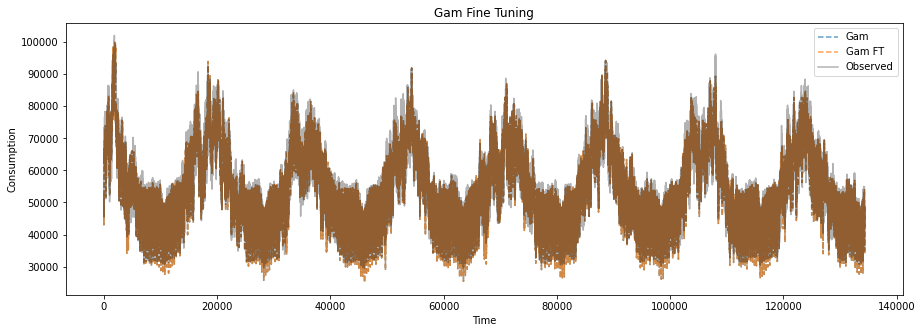

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.title('Gam Fine Tuning')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.plot(gamtrain, '--', label='Gam', alpha=.7)
plt.plot(ft_tr, '--', label='Gam FT', alpha=.7)
# plt.plot(delta_tr, '--', label='Gam Delta', alpha=.7)
plt.plot(train['Consommation'], label='Observed', color='black', alpha=.3)
plt.legend()
plt.show()

In [8]:
# Print MAPE
print('MAPE Gam: ', np.mean(np.abs(gamtrain - train['Consommation']) / train['Consommation']))
print('MAPE Gam FT: ', np.mean(np.abs(ft_tr - train['Consommation']) / train['Consommation']))
# print('MAPE Gam Delta: ', np.mean(np.abs(delta_tr - train['Consommation']) / train['Consommation']))

MAPE Gam:  0.05378146287489833
MAPE Gam FT:  0.053781462874897656
